# Running MAGEMin calculations through Julia

PetThermoTools provides the ability to run calculations/models that utilize the recent Weller et al. (2024) and Green et al. (2025) thermodynamic models. Once everything is set up you should be able to run these calculations from the same functions used to run models with alphaMELTS, but simply setting the ```Model``` kwarg to ```Green2025``` or ```Weller2024```.

I've worked hard to try and ensure a set up routine that works on every operating system, regardless of prior installations etc. There is, however, a good chance you'll come across a bug/issue I haven't seen before. If there is an issue in the following script please email me (gleesonm@berkeley.edu) and I will try to find a fix as quickly as possible!

**Please read the markdown cells carefully for instructions before each code cell**. If everything goes well you should be able to run calculations using the Weller et al. (2024) and Green et al. (2025) thermodynamic models!

### Step 1 
Uncomment the line below and install juliacall in your Python environment

In [1]:
# !pip install juliacall

### Step 2
Import Main as jl from juliacall. This means that we can call julia functions directly from Python by typing ```jl.{function_name}```.

In [1]:
from juliacall import Main as jl, convert as jlconvert

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Step 3
To ensure that this is going to work we need to remove any pre-existing julia packages that might interfere with ```PythonCall```. The main culprits are ```PyCall``` and ```Pandas```. If you are new to Julia or haven't done extensive work in Julia before, the easiest way to do this is to set `option1 = True` in the cell below. 

**If you use Julia and don't want to remove any other packages that you might need then please put `option2 = True` and `option1 = False`. This will just remove PyCall and Pandas.** If you select option 2 and then get issues later on in this notebook please let me know. If Pandas and/or PyCall are not installed in your Julia environment option 2 might return an error. This isn't as issue as long as neither of these packages are installed. If you're unsure what option to select and don't use Julia for other purposes, the safest option is to select option 1.

In [2]:
option1 = True
option2 = False
if option1:
    jl.seval("""
    using Pkg

    for pkg in values(Pkg.dependencies())  # Get metadata values instead of UUIDs
        if pkg.is_direct_dep  # Only remove explicitly installed packages
            Pkg.rm(pkg.name)  # Use the package name instead of UUID
        end
    end

    Pkg.gc()  # Clean up unused dependencies

    """)
elif option2:
    jl.seval("Using Pkg")
    jl.Pkg.rm("PyCall")
    jl.Pkg.rm("Pandas")

    Updating `~/anaconda3/julia_env/Project.toml`
  [6099a3de] - PythonCall v0.9.28
    Updating `~/anaconda3/julia_env/Manifest.toml`
  [992eb4ea] - CondaPkg v0.2.33
  [9a962f9c] - DataAPI v1.16.0
  [e2d170a0] - DataValueInterfaces v1.0.0
  [82899510] - IteratorInterfaceExtensions v1.0.0
  [0f8b85d8] - JSON3 v1.14.3
  [1914dd2f] - MacroTools v0.5.16
  [0b3b1443] - MicroMamba v0.1.14
  [bac558e1] - OrderedCollections v1.8.1
  [69de0a69] - Parsers v2.8.3
  [fa939f87] - Pidfile v1.3.0
  [aea7be01] - PrecompileTools v1.2.1
  [6099a3de] - PythonCall v0.9.28
  [6c6a2e73] - Scratch v1.3.0
  [856f2bd8] - StructTypes v1.11.0
  [3783bdb8] - TableTraits v1.0.1
  [bd369af6] - Tables v1.12.1
  [e17b2a0c] - UnsafePointers v1.0.0
  [f8abcde7] - micromamba_jll v1.5.12+0
  [4d7b5844] - pixi_jll v0.41.3+0
  [b77e0a4c] - InteractiveUtils v1.11.0
  [4af54fe1] - LazyArtifacts v1.11.0
  [a63ad114] - Mmap v1.11.0
  [9e88b42a] - Serialization v1.11.0
  [8dfed614] - Test v1.11.0
        Info We haven't cleane

### Step 4
Install ```PythonCall``` in Julia.

In [3]:
jl.Pkg.add("PythonCall")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/anaconda3/julia_env/Project.toml`
  [6099a3de] + PythonCall v0.9.28
    Updating `~/anaconda3/julia_env/Manifest.toml`
  [992eb4ea] + CondaPkg v0.2.33
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [692b3bcd] + JLLWrappers v1.7.1
  [0f8b85d8] + JSON3 v1.14.3
  [1914dd2f] + MacroTools v0.5.16
  [0b3b1443] + MicroMamba v0.1.14
  [bac558e1] + OrderedCollections v1.8.1
  [69de0a69] + Parsers v2.8.3
  [fa939f87] + Pidfile v1.3.0
⌅ [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.5.0
  [6099a3de] + PythonCall v0.9.28
  [6c6a2e73] + Scratch v1.3.0
  [856f2bd8] + StructTypes v1.11.0
  [3783bdb8] + TableTraits v1.0.1
  [bd369af6] + Tables v1.12.1
  [e17b2a0c] + UnsafePointers v1.0.0
⌅ [f8abcde7] + micromamba_jll v1.5.12+0
  [4d7b5844] + pixi_jll v0.41.3+0
  [0dad84c5] + ArgTools v1.1.2
  [56f22

### Step 5
Next we need to install MAGEMinCalc (my code) which will also install the underlying MAGEMin_C code (Riel et al. 2022). I've encountered some issues on Windows with this step, so if you originally get an error similar to that listed below then uncomment the line ```jl.seval('ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""')``` and rerun this cell.

```JuliaError: failed to clone from https://github.com/gleesonm1/MAGEMinCalc.git, error: GitError(Code:ERROR, Class:SSL, Your Julia is built with a SSL/TLS engine that libgit2 doesn't know how to configure to use a file or directory of certificate authority roots, but your environment specifies one via the SSL_CERT_FILE variable. If you believe your system's root certificates are safe to use, you can export JULIA_SSL_CA_ROOTS_PATH="" in your environment to use those instead.)```

In [4]:
# Set the environment variable inside Julia - uncomment if the code below returns an error.
# jl.seval('ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""')

### please check ReadTheDocs regularly for updates to the versions listed here.
# Install MAGEMinCalc
jl.Pkg.add(url="https://github.com/gleesonm1/MAGEMinCalc.git", rev="v0.4.5")
jl.Pkg.add(name = "MAGEMin_C", version="1.9.6") ## install last version of MAGEMin_C known to work with MAGEMinCalc

   Resolving package versions...
   Installed GPUCompiler ─ v1.6.3
   Installed Compat ────── v4.18.1
    Updating `~/anaconda3/julia_env/Project.toml`
  [dd69d18c] + MAGEMinCalc v0.4.4 `https://github.com/gleesonm1/MAGEMinCalc.git#v0.4.4`
    Updating `~/anaconda3/julia_env/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [79e6a3ab] + Adapt v4.4.0
  [a9b6321e] + Atomix v1.1.2
  [ab4f0b2a] + BFloat16s v0.5.1
  [26cce99e] + BasicInterpolators v0.7.1
⌅ [fa961155] + CEnum v0.4.2
  [336ed68f] + CSV v0.10.15
  [052768ef] + CUDA v5.9.0
  [1af6417a] + CUDA_Runtime_Discovery v1.0.0
  [944b1d66] + CodecZlib v0.7.8
  [3da002f7] + ColorTypes v0.12.1
  [5ae59095] + Colors v0.13.1
  [34da2185] + Compat v4.18.1
  [187b0558] + ConstructionBase v1.6.0
  [a8cc5b0e] + Crayons v4.1.1
  [a93c6f00] + DataFrames v1.8.0
  [864edb3b] + DataStructures v0.19.1
  [e2ba6199] + ExprTools v0.1.10
  [48062228] + FilePathsBase v0.9.24
  [53c48c17] + FixedPointNumbers v0.8.5
  [0c68f7d7] + GPUArrays v11.2.5
  [4619

### Step 6
Precompile the Julia packages to check for any issues.

In [5]:
jl.Pkg.precompile()

### Step 7
Test the installation by running the following cell. This is calling the MAGEMinCalc functions directly with Julia code using juliacall. This is different to how the code is usually initiated in PetThermoTools but it provides an initial test of the installation. If successful it should print a Pandas DataFrame containing the predicted melt compositions in this crystallization example:

In [6]:
jl.seval("""
using MAGEMinCalc

comp = Dict("SiO2_Liq" => 47.5, "Al2O3_Liq" => 16.4, "CaO_Liq" => 11.6, "MgO_Liq" => 9.38,
            "FeOt_Liq" => 9.16, "K2O_Liq" => 0.329, "Na2O_Liq" => 2.25, "TiO2_Liq" => 2.29, 
            "Fe3Fet_Liq" => 0.15, "Cr2O3_Liq" => 0.0, "H2O_Liq" => 0.68)

Results = MAGEMinCalc.path(comp = comp, T_end_C = 1100.0, dt_C = 2.0, 
            P_bar = 1000.0, frac_xtal = true, 
            Model = "ig",
            find_liquidus = true)

""")

jl.Results["liq1"]

Using libMAGEMin.dylib from MAGEMin_jll
ig


,SiO2,Al2O3,CaO,MgO,FeO,K2O,Na2O,TiO2,O,Cr2O3,H2O
0,0.476268,0.164408,0.116310,0.094024,0.091840,0.003298,0.022562,0.022951,0.001524,0.0,0.006816
1,0.476331,0.164614,0.116466,0.093525,0.091863,0.003298,0.022590,0.022962,0.001526,0.0,0.006824
2,0.476385,0.164872,0.116649,0.093006,0.091824,0.003306,0.022612,0.022988,0.001527,0.0,0.006830
3,0.476507,0.165105,0.116775,0.092487,0.091789,0.003312,0.022641,0.023015,0.001529,0.0,0.006840
4,0.476598,0.165332,0.116902,0.091962,0.091758,0.003323,0.022680,0.023068,0.001531,0.0,0.006845
5,0.476756,0.165518,0.117051,0.091448,0.091724,0.003320,0.022717,0.023077,0.001534,0.0,0.006854
6,0.476844,0.165743,0.117196,0.090934,0.091686,0.003318,0.022761,0.023118,0.001536,0.0,0.006865
7,0.476901,0.165958,0.117347,0.090415,0.091703,0.003317,0.022791,0.023160,0.001539,0.0,0.006870
8,0.476947,0.166224,0.117515,0.089910,0.091650,0.003320,0.022832,0.023181,0.001542,0.0,0.006881
9,0.477039,0.166459,0.117718,0.089416,0.091567,0.003325,0.022853,0.023189,0.001543,0.0,0.006892


## Step 8 - You need to restart your kernal before running any of the code below!
Assuming the crystallization model above ran without any issues we can now progress to testing the integration of MAGEMin with PetThermoTools. First make sure you have the up to date version of PetThermoTools installed (v0.2.32 or later).

In [7]:
# !pip install --upgrade PetThermoTools

In [1]:
import PetThermoTools as ptt
ptt.__version__

'0.2.42'

### Step 9
We are now going to run the same crystallization model as we did above, but this time through PetThermoTools. You don't need to change anything, the two cells of code below should run the model and plot a simple graph of MgO vs FeOt. Expect the code to take 10 - 60 seconds depending on your computer performance.

In [2]:
comp = {"SiO2_Liq": 47.5, 
        "Al2O3_Liq": 16.4, 
        "CaO_Liq": 11.6, 
        "MgO_Liq": 9.38,
        "FeOt_Liq": 9.16, 
        "K2O_Liq": 0.329, 
        "Na2O_Liq": 2.25, 
        "TiO2_Liq": 2.29,
        "Fe3Fet_Liq": 0.15, 
        "Cr2O3_Liq": 0.0, 
        "H2O_Liq": 0.68}

Results = ptt.isobaric_crystallisation(bulk=comp,
                             Model = "Green2025",
                             dt_C = 2.0,
                             T_end_C=1100.0,
                             P_bar=1000.0,
                             find_liquidus=True,
                             Frac_solid=True)

Running Green2025 calculation...

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Using libMAGEMin.dylib from MAGEMin_jll
ig
 Complete (time taken = 41.07 seconds)

Text(0, 0.5, 'FeO$_t$')

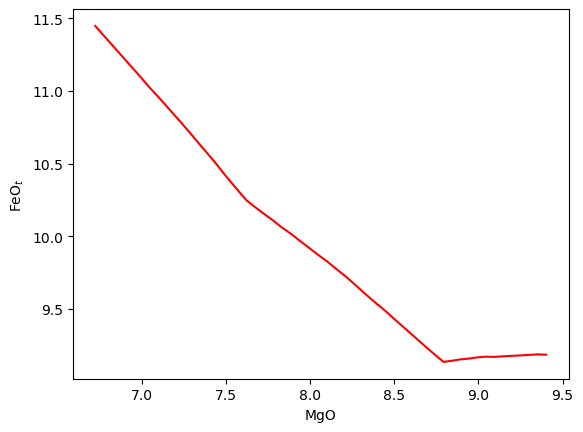

In [3]:
import matplotlib.pyplot as plt
plt.plot(Results["All"]["MgO_Liq"], Results["All"]["FeOt_Liq"], '-r')
plt.xlabel('MgO')
plt.ylabel('FeO$_t$')

### Step 10 - use PetThermoTools alongside MAGEMin in your research!